In [17]:
import seaborn as sns
import matplotlib.pyplot as plt
import pandas as pd
import numpy as np

In [18]:
#reload modules
%load_ext autoreload
%autoreload 2

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


In [19]:
import join_data as jd

In [20]:
from helpers import *

# Load and join the public data

In [21]:
mergeddfpublic = jd.pipeline(directory = '../data/', FSfilename = 'FSR_221022.csv', FIfilename = 'FI_221022.csv', FWOfilename = 'FWO_221022.csv', FRAfilename = 'FRA_221024.csv')

In [22]:
mergeddfpublic.columns

Index(['OBJECTID', 'SRCategory', 'SRType', 'SRPriority', 'SRSource',
       'SRStatus', 'SRResolution', 'Borough', 'CommunityBoard',
       'ServiceRequestParentGlobalID', 'GlobalID', 'InitiatedDate',
       'SRClosedDate', 'SRCreatedDate', 'SRUpdatedDate', 'Descriptor1',
       'ComplaintType', 'CallerZipCode', 'SRCallerType', 'Latitude',
       'Longitude', 'Census Tract', 'NTA', 'SRGlobalID', 'InspectionType',
       'InspectionStatus', 'InspectionTPCondition', 'InspectionTPStructure',
       'TreePointDBH', 'InsGlobalID', 'InspectionDate', 'InsClosedDate',
       'InsCreatedDate', 'InsUpdatedDate', 'ParentInspectionGlobalID',
       'ReinspectionDate', 'Location', 'WOType', 'WOStatus', 'WOPriority',
       'ActualFinishDate', 'CancelReason', 'WOCategory', 'WOGlobalID',
       'WOClosedDate', 'CancelDate', 'WOCreatedDate', 'WOUpdatedDate',
       'WOEntity', 'PROJSTARTDATE', 'WOProject', 'RecommendedSpecies',
       'Location_WO', 'RADefect', 'RADefectLocation', 'Failure',
       'I

# Calculate work order delays

First, combine multiple reports of the same incident so that I have one row per unique incident. If there are multiple inspections or work orders, grab date of the first inspection/work order

In [23]:
nodups = mergeddfpublic[['IncidentGlobalID','SRCategory','SRCreatedDate', 'InspectionDate','WOClosedDate','Risk_coded','RiskRating','Borough','InspectionTPCondition', 'InspectionTPStructure',
       'TreePointDBH', 'ActualFinishDate']].groupby('IncidentGlobalID').agg(
    {'SRCreatedDate': 'min', 'InspectionDate': 'min', 'WOClosedDate': 'min', 'SRCategory': 'first', 'Risk_coded': 'first', 'Borough': 'first', 'RiskRating': 'first', 'InspectionTPCondition': 'first', 'InspectionTPStructure': 'first',
       'TreePointDBH': 'first', 'ActualFinishDate':'min'}).reset_index()

In [24]:
wofinishdatecolumn = 'ActualFinishDate' # 'WOClosedDate'

In [25]:
# calculate inspection and work order delays
nodups['inspection_delay'] = (nodups['InspectionDate'] - nodups['SRCreatedDate']).dt.total_seconds() / 3600 /24

nodups['work_delay'] = (nodups[wofinishdatecolumn] - nodups['InspectionDate']).dt.total_seconds() / 3600 /24

In [26]:
# nodups[['SRCreatedDate','InspectionDate', 'WOClosedDate']].describe(datetime_is_numeric=True)

# Work order delays for entire dataset

In [27]:
nodups.groupby(['Risk_coded', 'Borough'])['work_delay'].median()

Risk_coded  Borough      
A           Bronx             11.792222
            Brooklyn           3.405434
            Manhattan          0.000000
            Queens             4.743808
            Staten Island      1.809034
B           Bronx             21.696991
            Brooklyn           5.441887
            Manhattan          0.188866
            Queens             4.000000
            Staten Island      8.050463
C           Bronx             59.858600
            Brooklyn          47.771696
            Manhattan          5.571875
            Queens            50.744803
            Staten Island     58.667078
D           Bronx             56.595041
            Brooklyn          33.000000
            Manhattan         16.502072
            Queens            24.643623
            Staten Island     65.629676
E           Bronx             57.583333
            Brooklyn                NaN
            Queens           740.541042
Unknown     Bronx             40.590521
            Br

In [28]:
nodups.groupby(['SRCategory', 'Borough'])['work_delay'].median()

SRCategory           Borough      
Claims               Bronx                   NaN
                     Brooklyn         381.703866
                     Manhattan               NaN
                     Queens                  NaN
                     Staten Island           NaN
Hazard               Bronx              3.948611
                     Brooklyn           9.641528
                     Manhattan          0.800532
                     Queens             5.000000
                     Staten Island      4.348831
Illegal Tree Damage  Bronx             97.520683
                     Brooklyn          60.833333
                     Manhattan          8.000000
                     Queens            42.654676
                     Staten Island     74.764884
Pest/Disease         Bronx             68.852049
                     Brooklyn          98.681308
                     Manhattan         26.586088
                     Queens           211.958333
                     Staten Island

# If an incident got inspected but no work order, pretend it had a really long work order delay

In [29]:
nodups_imputed = nodups.copy()
nodups_imputed.loc[:, 'work_delay'] = nodups_imputed['work_delay'].fillna(10000)

In [30]:
# only look at inspected incidents
nodups_imputed = nodups_imputed.dropna(subset = ['inspection_delay'])

In [31]:
nodups_imputed.groupby(['Risk_coded', 'Borough'])['work_delay'].median()

Risk_coded  Borough      
A           Bronx               14.901690
            Brooklyn             5.000000
            Manhattan            0.000000
            Queens               6.598009
            Staten Island        3.423032
B           Bronx               35.597049
            Brooklyn             7.530833
            Manhattan            0.587731
            Queens               5.773113
            Staten Island       11.434178
C           Bronx              493.249213
            Brooklyn           139.904190
            Manhattan            8.195839
            Queens             275.343646
            Staten Island      158.419873
D           Bronx            10000.000000
            Brooklyn         10000.000000
            Manhattan          131.717755
            Queens           10000.000000
            Staten Island    10000.000000
E           Bronx            10000.000000
            Brooklyn         10000.000000
            Queens           10000.000000
Unknown 

In [32]:
nodups_imputed.groupby(['SRCategory', 'Borough'])['work_delay'].median()

SRCategory           Borough      
Claims               Bronx            10000.000000
                     Brooklyn           381.703866
                     Queens           10000.000000
Hazard               Bronx              457.422263
                     Brooklyn         10000.000000
                     Manhattan            1.958333
                     Queens             116.566065
                     Staten Island       29.742998
Illegal Tree Damage  Bronx            10000.000000
                     Brooklyn         10000.000000
                     Manhattan        10000.000000
                     Queens           10000.000000
                     Staten Island    10000.000000
Pest/Disease         Bronx            10000.000000
                     Brooklyn         10000.000000
                     Manhattan        10000.000000
                     Queens           10000.000000
                     Staten Island    10000.000000
Plant Tree           Bronx              240.704

# Only look at 2017 - 2020 like in the paper, and other filtering (e.g., where reports are defined, subset of categories)

In [33]:
# filter to categories that we're analysing in the paper
nodups = nodups[nodups['SRCategory'].isin(['Hazard', 'Remove Tree', 'Root/Sewer/Sidewalk', 'Prune','Illegal Tree Damage'])]

#if these fields are NA we didn't have data to calculate reporting delay
nodups = nodups.dropna(subset = ['RiskRating', 'Borough', 'SRCategory', 'Risk_coded', 'InspectionTPCondition', 'TreePointDBH'])

In [34]:
nodups_rightdate = nodups[(nodups['SRCreatedDate'] >= '2017-06-30') & (nodups['SRCreatedDate'] < '2020-07-01')]

nodups_right_dateimputed = nodups_rightdate.copy()
nodups_right_dateimputed.loc[:, 'work_delay'] = nodups_right_dateimputed['work_delay'].fillna(10000)
# only look at inspected incidents
nodups_right_dateimputed = nodups_right_dateimputed.dropna(subset = ['inspection_delay'])

In [35]:
nodups_rightdate.dropna(subset = ['inspection_delay']).groupby(['Risk_coded', 'Borough'])['work_delay'].median()

Risk_coded  Borough      
A           Bronx              8.653275
            Brooklyn           1.000000
            Manhattan          0.000000
            Queens             4.772760
            Staten Island      6.812720
B           Bronx             28.421869
            Brooklyn           3.618507
            Manhattan          0.000000
            Queens             4.706406
            Staten Island     21.693009
C           Bronx            102.726713
            Brooklyn          59.002824
            Manhattan          3.053131
            Queens            73.636238
            Staten Island    117.566898
D           Bronx            111.060770
            Brooklyn          46.612558
            Manhattan         19.000000
            Queens            48.733426
            Staten Island    112.659404
E           Bronx             57.583333
            Brooklyn                NaN
            Queens           740.541042
Unknown     Bronx            130.092500
            Br

In [36]:
# with imputation
nodups_right_dateimputed.groupby(['Risk_coded', 'Borough'])['work_delay'].median()

Risk_coded  Borough      
A           Bronx               17.947153
            Brooklyn             1.710914
            Manhattan            0.000000
            Queens               6.623079
            Staten Island        8.247431
B           Bronx               49.707627
            Brooklyn             5.659699
            Manhattan            0.000000
            Queens               6.668970
            Staten Island       27.348374
C           Bronx              502.366065
            Brooklyn           136.664236
            Manhattan            5.000000
            Queens             211.685579
            Staten Island      192.484554
D           Bronx            10000.000000
            Brooklyn         10000.000000
            Manhattan          126.041667
            Queens           10000.000000
            Staten Island    10000.000000
E           Bronx            10000.000000
            Brooklyn         10000.000000
            Queens           10000.000000
Unknown 

## Just split by year

In [ ]:
(nodups['SRCreatedDate'] >= '2017-06-30') & (nodups['SRCreatedDate'] < '2020-07-01')

In [64]:
for year in range(2017, 2021):
    print(year)
    yearquery = f"SRCreatedDate >= '{year}-01-01' and SRCreatedDate <= '{year}-12-31'"
    print(nodups_right_dateimputed.query(yearquery).groupby(['Risk_coded', 'Borough'])['work_delay'].median())

2017
Risk_coded  Borough      
A           Bronx               36.902662
            Brooklyn             9.634063
            Manhattan            0.000000
            Queens              14.687199
            Staten Island       27.815370
B           Bronx              154.699178
            Brooklyn            27.592471
            Manhattan            0.000000
            Queens              62.641331
            Staten Island       41.858623
C           Bronx             1066.328715
            Brooklyn           136.154751
            Manhattan            8.157078
            Queens             484.679907
            Staten Island      251.246111
D           Bronx            10000.000000
            Brooklyn         10000.000000
            Manhattan           41.000000
            Queens           10000.000000
            Staten Island    10000.000000
E           Queens             759.590324
Unknown     Bronx              706.274936
            Brooklyn           238.052222
   

<Axes: xlabel='year', ylabel='work_delay'>

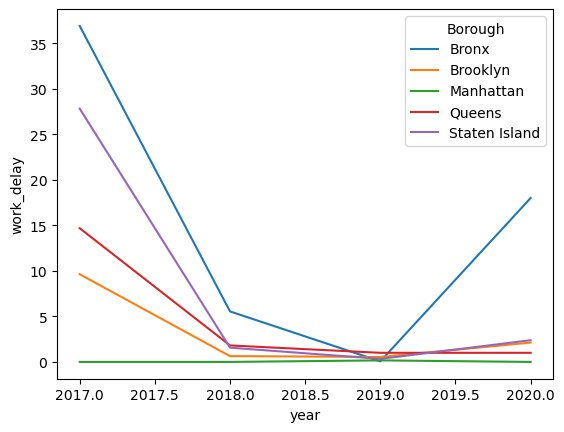

In [76]:
# # This plot shows the median delay for Risk code A and B incidents in each Borough and year.
sns.lineplot(x = 'year', y = 'work_delay', hue = 'Borough', data = nodups_right_dateimputed.query('Risk_coded == "A"').groupby(['year','Borough'])['work_delay'].median().reset_index())